In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torchvision

from sklearn.model_selection import train_test_split

%matplotlib inline

In [2]:
# Import training dataset
df_train = pd.read_csv('train.csv')

In [3]:
# Define dictionary of output to description
Emotion = {0:'Anger',
           1:'Disgust',
           2:'Fear',
           3:'Happy',
           4:'Sad',
           5:'Surprise',
           6:'Neutral'}

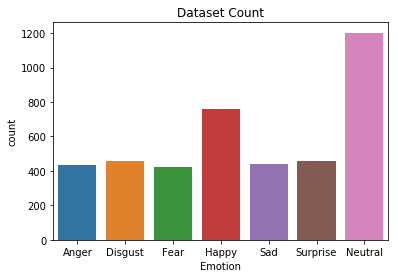

In [4]:
# Display dataset distribution
ax = sns.countplot(df_train['Emotion'])
ax.set(xticklabels = Emotion.values(), title = "Dataset Count")
plt.show()

In [5]:
# Define validation size set
val_size = 0.2

# Create a 3D array for our feature values
X = df_train['Pixels'].str.split(" ", expand = True)
X = np.asarray(X).astype(float)
X = X/255.0
X = X.reshape(-1,1,48,48)

# Create a 1D array for our target values
y = np.asarray(df_train['Emotion']).reshape(-1,1).astype(int)

# Stratify split the dataset to train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, stratify = y)

print(f'The number of items in X_train is {len(X_train)}.\nThe number of items in y_train is {len(y_train)}.\n')
print(f'The number of items in X_train is {len(X_val)}.\nThe number of items in y_train is {len(y_val)}.')

The number of items in X_train is 3342.
The number of items in y_train is 3342.

The number of items in X_train is 836.
The number of items in y_train is 836.


In [6]:
# Define function to display sample data
def display_tensor(x,y):
    plt.figure(figsize = (5,5))
    plt.imshow(x.reshape(48,48), cmap = 'gray')
    plt.title(y)
    plt.show()


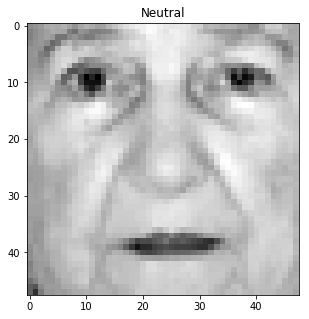

In [7]:
import random

ran = random.randint(0,len(X_train))
display_tensor(X[ran], Emotion[int(y[ran])])

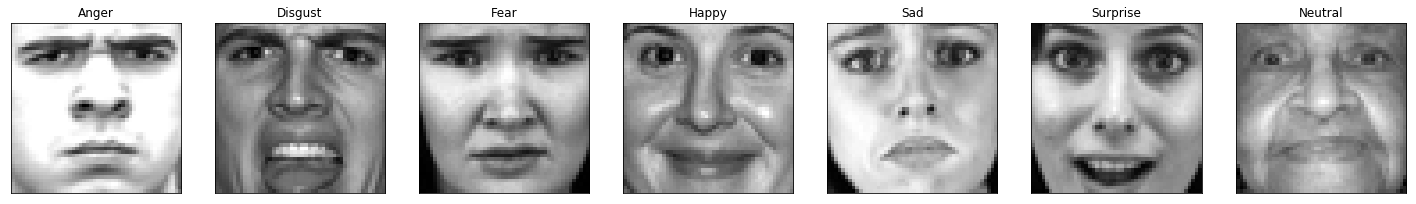

In [8]:
# Display sample faces per emotion
fig = plt.figure(figsize=(25, 4))
for i in range(len(Emotion)):
    ax = fig.add_subplot(1, 7, i+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(X_train[np.argmax(y_train == i)].reshape(48,48)), cmap='gray')
    ax.set_title(Emotion[int(y_train[np.argmax(y_train == i)])])

In [9]:
# Create PyTorch dataset from numpy

import torch.utils.data as utils
import torchvision.transforms as transforms

# Create tensors for train set
tensor_x = torch.stack([torch.Tensor(i) for i in X_train])
tensor_y = torch.stack([torch.Tensor(i) for i in y_train])

# Create train dataset
train_data = utils.TensorDataset(tensor_x, tensor_y)

# Create tensors for validation set
tensor_x = torch.stack([torch.Tensor(i) for i in X_val])
tensor_y = torch.stack([torch.Tensor(i) for i in y_val])

# Create validation dataset
valid_data = utils.TensorDataset(tensor_x, tensor_y)

In [10]:
# Define loading parameters and transforms
num_workers = 0
batch_size = 20

train_transform = transforms.Compose([transforms.ToTensor(),
                                      transforms.RandomHorizontalFlip()])
valid_transform = transforms.Compose([transforms.ToTensor()])

In [11]:
# Define data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size,
                                           shuffle = True, num_workers = num_workers)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size = batch_size,
                                           shuffle = True, num_workers = num_workers)

In [12]:
import torch.nn as nn
import torch.nn.functional as F

# https://arxiv.org/pdf/1302.4389v3.pdf  (student assistant solution)
# https://arxiv.org/ftp/arxiv/papers/1706/1706.01509.pdf (paper about emotion detection)

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Convolutional layer (sees 48x48x1 image tensor)
        self.conv1 = nn.Conv2d(1, 20, 5, padding = 3)
        # Convolutional layer (sees 24x24x10 image tensor)
        self.conv2 = nn.Conv2d(20, 20, 5, padding = 3)
        # Convolutional layer (sees 12x12x10 image tensor)
        self.conv3 = nn.Conv2d(20, 20, 3, padding = 1)
        
        self.maxpool = nn.MaxPool2d(2,2)
        
        self.fc1 = nn.Linear(20*6*6, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 7)
        
        self.dropout = nn.Dropout(p = 0.25)
        
        self.logsoftmax = nn.LogSoftmax(dim = 1)
        
    def forward(self, x):
        x = self.maxpool(F.relu(self.conv1(x)))
        x = self.maxpool(F.relu(self.conv2(x)))
        x = self.maxpool(F.relu(self.conv3(x)))
        x = x.view(-1, 6*6*20)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

model = Net()

In [13]:
# This line is added to upload the current best model parameters into the model based on previous training
# This line should not be used if the model was changed

# model.load_state_dict(torch.load('model.pth'))

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)

In [15]:
from torch.autograd import Variable

n_epoch = 300

valid_loss_min = np.Inf
change_lr = 0
curr_lr = 0.01

for epoch in range(n_epoch):
    train_loss = 0
    valid_loss = 0

    
    model.train()
    model.to('cuda')
    
    if epoch == 100:
        optimizer = torch.optim.SGD(model.parameters(), lr = 0.001)
    if epoch == 200:
        optimizer = torch.optim.SGD(model.parameters(), lr = 0.0001)
    
    for data, target in train_loader:
        data, target = data.to('cuda'), target.to('cuda')
        target = target.squeeze()
        optimizer.zero_grad()
        output = model.forward(data)
        loss = criterion(output, target.long()) 
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * data.size(0)
        
    model.eval()
    
    for data, target in valid_loader:
        data, target = data.to('cuda'), target.to('cuda')
        target = target.squeeze()
        output = model.forward(data)
        loss = criterion(output, target.long())
        valid_loss += loss.item() * data.size(0)
    
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
    
    print('Epoch {}\tTraining Loss: {:.6f}\tValidation Loss: {:.6f}'.format(
                epoch+1,
                train_loss,
                valid_loss,
                change_lr))
    
    if valid_loss < valid_loss_min:
        print('Validation loss improved ({:.6f} --> {:.6f})'.format(
                valid_loss_min,
                valid_loss))
        torch.save(model.state_dict(), 'model.pth')
        valid_loss_min = valid_loss


Epoch 1	Training Loss: 1.921711	Validation Loss: 1.887724
Validation loss improved (inf --> 1.887724)
Epoch 2	Training Loss: 1.864343	Validation Loss: 1.856618
Validation loss improved (1.887724 --> 1.856618)
Epoch 3	Training Loss: 1.854427	Validation Loss: 1.854980
Validation loss improved (1.856618 --> 1.854980)
Epoch 4	Training Loss: 1.855537	Validation Loss: 1.857397
Epoch 5	Training Loss: 1.853213	Validation Loss: 1.857603
Epoch 6	Training Loss: 1.853125	Validation Loss: 1.856821
Epoch 7	Training Loss: 1.851508	Validation Loss: 1.860004
Epoch 8	Training Loss: 1.849862	Validation Loss: 1.852338
Validation loss improved (1.854980 --> 1.852338)
Epoch 9	Training Loss: 1.848180	Validation Loss: 1.850909
Validation loss improved (1.852338 --> 1.850909)
Epoch 10	Training Loss: 1.847060	Validation Loss: 1.850237
Validation loss improved (1.850909 --> 1.850237)
Epoch 11	Training Loss: 1.845431	Validation Loss: 1.851976
Epoch 12	Training Loss: 1.843719	Validation Loss: 1.845066
Validation l

Epoch 101	Training Loss: 0.344127	Validation Loss: 0.593070
Validation loss improved (0.606047 --> 0.593070)
Epoch 102	Training Loss: 0.330715	Validation Loss: 0.592706
Validation loss improved (0.593070 --> 0.592706)
Epoch 103	Training Loss: 0.313715	Validation Loss: 0.592396
Validation loss improved (0.592706 --> 0.592396)
Epoch 104	Training Loss: 0.301934	Validation Loss: 0.592642
Epoch 105	Training Loss: 0.292240	Validation Loss: 0.601845
Epoch 106	Training Loss: 0.296502	Validation Loss: 0.603918
Epoch 107	Training Loss: 0.306851	Validation Loss: 0.606699
Epoch 108	Training Loss: 0.302385	Validation Loss: 0.613094
Epoch 109	Training Loss: 0.303736	Validation Loss: 0.604803
Epoch 110	Training Loss: 0.305167	Validation Loss: 0.611824
Epoch 111	Training Loss: 0.293449	Validation Loss: 0.604182
Epoch 112	Training Loss: 0.273189	Validation Loss: 0.602553
Epoch 113	Training Loss: 0.302352	Validation Loss: 0.608774
Epoch 114	Training Loss: 0.294882	Validation Loss: 0.620994
Epoch 115	Tra

Epoch 235	Training Loss: 0.224131	Validation Loss: 0.627463
Epoch 236	Training Loss: 0.224197	Validation Loss: 0.628121
Epoch 237	Training Loss: 0.239472	Validation Loss: 0.626950
Epoch 238	Training Loss: 0.217008	Validation Loss: 0.628829
Epoch 239	Training Loss: 0.232476	Validation Loss: 0.628919
Epoch 240	Training Loss: 0.213207	Validation Loss: 0.629288
Epoch 241	Training Loss: 0.221054	Validation Loss: 0.628508
Epoch 242	Training Loss: 0.220301	Validation Loss: 0.627087
Epoch 243	Training Loss: 0.226630	Validation Loss: 0.627933
Epoch 244	Training Loss: 0.225486	Validation Loss: 0.626412
Epoch 245	Training Loss: 0.215581	Validation Loss: 0.627698
Epoch 246	Training Loss: 0.220472	Validation Loss: 0.627264
Epoch 247	Training Loss: 0.214943	Validation Loss: 0.627031
Epoch 248	Training Loss: 0.208628	Validation Loss: 0.628567
Epoch 249	Training Loss: 0.224752	Validation Loss: 0.628928
Epoch 250	Training Loss: 0.226611	Validation Loss: 0.627758
Epoch 251	Training Loss: 0.222030	Valida

In [16]:
def test_model(img, label, model):
    X = torch.Tensor(img.reshape(1,1,48,48))
    output = model(X)
    _, pred = torch.max(output,1)
    Emotion[int(pred)], label, pred
    display_tensor(X, f'Prediction: {Emotion[int(pred)]}\nActual:{label}')

In [17]:
# This line is added to upload the current best model parameters into the model based on previous training
model.load_state_dict(torch.load('model.pth'))

In [18]:
model.to('cpu')
from tqdm import tqdm

y_pred = []
corr = 0
for i in tqdm(range(len(X_val))):
    output = model(torch.Tensor(X_val[i].reshape(1,1,48,48)))
    _, pred = torch.max(output,1)
    y_pred.append(pred)
    if int(pred) == int(y_val[i]):
        corr += 1

print(corr/len(X_val))

100%|███████████████████████████████████████████████████████████████████████████████| 836/836 [00:01<00:00, 459.78it/s]


0.812200956937799


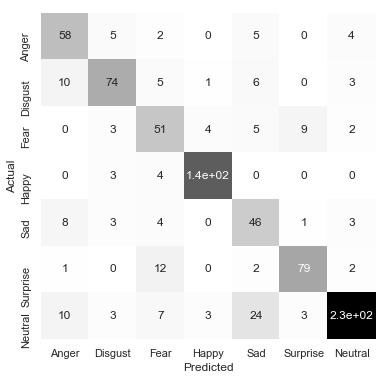

In [19]:
from sklearn.metrics import confusion_matrix

sns.set(rc={'figure.figsize':(6,6)})
ax = sns.heatmap(confusion_matrix(y_pred, y_val), cmap='gray_r', 
                 annot = True, cbar = False, 
                 xticklabels = list(Emotion.values()),
                 yticklabels = list(Emotion.values()))
ax.set(xlabel='Predicted', ylabel='Actual')
plt.show()

In [22]:
corr = 0
wrong =[]

for i in tqdm(range(len(X_val))):
    output = model(torch.Tensor(X_val[i].reshape(1,1,48,48)))
    _, pred = torch.max(output,1)
    if int(pred) == int(y_val[i]):
        corr += 1
    else:
        wrong.append(i)
print(corr/len(X_val))

100%|███████████████████████████████████████████████████████████████████████████████| 836/836 [00:01<00:00, 490.78it/s]


0.812200956937799


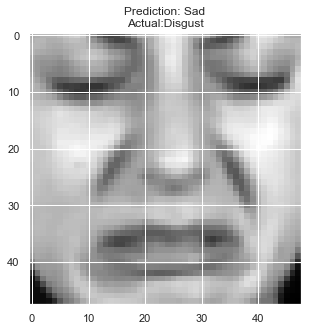

In [24]:
ran = wrong[6]

test_model(X_val[ran], Emotion[int(y_val[ran])], model)